In [70]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# ourverture du csv

In [87]:

# Lecture du fichier CSV avec parse_dates
df = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2020-04-22.csv')



# Transformer le timestamp en date avec heure
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
df.set_index('Timestamp', inplace=True)
# Échantillonnage des données (une ligne sur 15)
df = df.iloc[-1440::15]
df = df[["Open", "Volume_(BTC)", "Weighted_Price"]]
print(df.head())


                        Open  Volume_(BTC)  Weighted_Price
Timestamp                                                 
2020-04-21 00:01:00  6824.40      9.370150     6831.870216
2020-04-21 00:16:00  6878.14      1.931543     6872.211053
2020-04-21 00:31:00  6886.66      0.009331     6886.660000
2020-04-21 00:46:00  6901.83      4.968683     6901.927286
2020-04-21 01:01:00  6893.51      0.767481     6899.935507


# Normalisation

C:\Users\chauv\AppData\Local\Temp\ipykernel_6976\3945636508.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df.keys(), rotation=90)


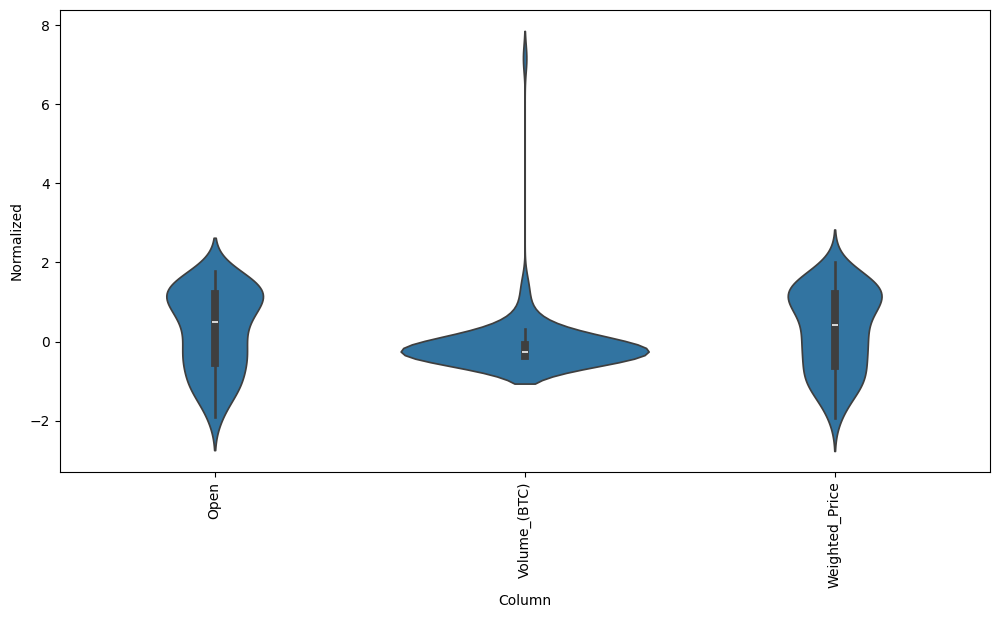

In [88]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[1:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

plt.show()



# Fenetrage des données

In [136]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
  
  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

  

# création d'instances de fentre

In [77]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['Open'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['Open']

In [116]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['Volume_(BTC)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['Volume_(BTC)']

Étant donné une liste d'entrées consécutives, la méthode split_window les convertira en une fenêtre d'entrées et une fenêtre d'étiquettes.

In [137]:
w2 = WindowGenerator(input_width=10, label_width=1, shift=2,
                     label_columns=['Open'])
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[10:10+w2.total_window_size]),
                           np.array(train_df[50:50+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 12, 3)
Inputs shape: (3, 10, 3)
Labels shape: (3, 1, 1)


Terrain   

In [138]:

w2.example = example_inputs, example_labels
print("w2 shape", w2.example[1].shape)
def plot(self, model=None, plot_col='Volume_(BTC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

w2.plot()
w2.plot(plot_col='Open')

w2 shape (3, 1, 1)


AttributeError: 'WindowGenerator' object has no attribute 'plot'

AttributeError: 'WindowGenerator' object has no attribute 'example'

## Création du dataset

In [139]:
w2.train.element_spec

AttributeError: 'WindowGenerator' object has no attribute 'train'